## Visión computacional: Segmentación de imagenes

En este notebook se realiza una exploración de diferentes técnicas para la segmentación de imagenes desde funciones base has métodos más complejos basado en redes neuronales.

## Parte 1. Exploración de la segmentación de imagenes

In [ ]:
# Cargar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import hsv_to_rgb
from matplotlib.colors import Normalize

import cv2
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

from skimage.color import rgb2gray, label2rgb
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import (active_contour, felzenszwalb, quickshift, 
                                 mark_boundaries, slic, clear_border, watershed)

from skimage.future.graph import rag_mean_color, cut_normalized, cut_threshold
import io

from itertools import product

In [ ]:
# Defino una función para mostrar una imagen por pantalla con el criterio que considero más acertado
def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))
    # El comando que realmente muestra la imagen
    ax.imshow(img,cmap=plt.cm.gray)
    # Para evitar que aparezcan los números en los ejes
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()

In [ ]:
# Función para comparar cómo de buena es una determinada segmentación en comparación con el ground truth
# Ambas imagenes deben contener valores True/False
def factor_f_evaluation(binary_image, ground_truth):
    TP = np.sum(np.logical_and(binary_image, ground_truth))
    TN = np.sum(np.logical_and(np.logical_not(binary_image), np.logical_not(ground_truth)))
    FP = np.sum(np.logical_and(np.logical_not(binary_image), ground_truth))
    FN = np.sum(np.logical_and(binary_image, np.logical_not(ground_truth)))
    P = TP/np.float(TP+FP)
    R = TP/np.float(TP+FN)
    if P+R == 0:
        F = 0
    else:
        F = 2*P*R/(P+R)
    return F


Descarga de la imagen de referencia

In [ ]:
# https://lmb.informatik.uni-freiburg.de/resources/datasets/moseg.en.html
patos = data.imread('img/ducks01_0100.jpg')/255
gt_patos = rgb2gray(data.imread('img/ducks01_0100_gt.ppm'))<1

**Visualización de la imagen original**

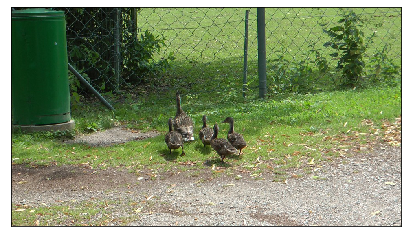

In [ ]:
# Se visualiza la imagen cargada - img/ducks01_0100.jpg
imshow(patos)

Visualización de la imagen segementada (máscara

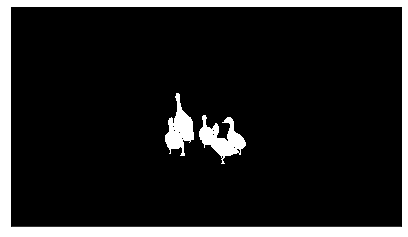

In [ ]:
# Se visualiza la imagen cargada - img/ducks01_0100_gt.ppm
imshow(gt_patos)

Se realiza una prueba de los siguientes filtros de segmentación disponibles:
 - felzenszwalb
 - quickshift
 - slic

### SLIC con RAG Thresholding 

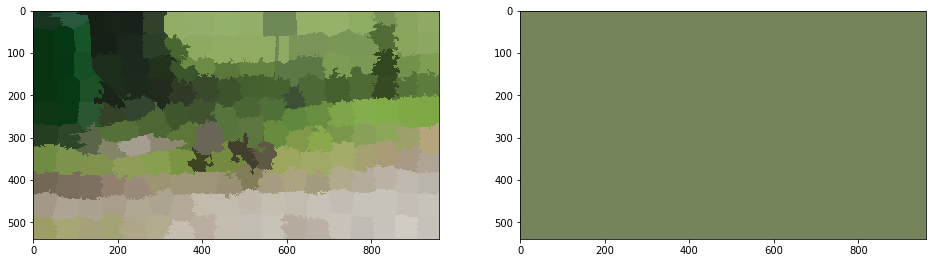

In [ ]:
labels1 = slic(patos, compactness=30, n_segments=180)
out1_slic = label2rgb(labels1, patos, kind='avg')

g = rag_mean_color(patos, labels1)
labels2 = cut_threshold(labels1, g, 29)
out2 = label2rgb(labels2, patos, kind='avg')

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

ax[0].imshow(out1_slic)
ax[1].imshow(out2)

Este modelo de segmentación (Simple Linear Iterative Clustering) crea filtros de Dilatación con un patrón hexagonal. Se realiza una consolidación o mezcla de colores disminuyendo la cantidad de colores de la imagen mediante el cálculo del color promedio. se observa que en la primera imagen se separan mejor los colores de cuatro de los patos pero para uno no es muy clara la segmentación. 

### SLIC con Normalized Cut 

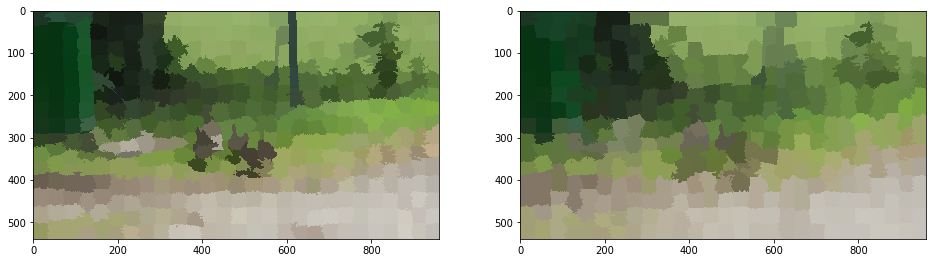

In [ ]:
labels1 = slic(patos, compactness=30, n_segments=400)
out1_slic2 = label2rgb(labels1, patos, kind='avg')

g = rag_mean_color(patos, labels1)
labels2 = cut_normalized(labels1, g, 29)
out2 = label2rgb(labels2, patos, kind='similarity')

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

ax[0].imshow(out1_slic2)
ax[1].imshow(out2)

En este modelo de segmentación se prueba utilizando un valor más alto de segmentos y utilizando la agregación por similaridad de colores para identificar el layout. en este filtro se observa que no logra hacer una mejor segmentación de la figura de los patos que en el anterior.

### felzenszwalb con cut_normalized

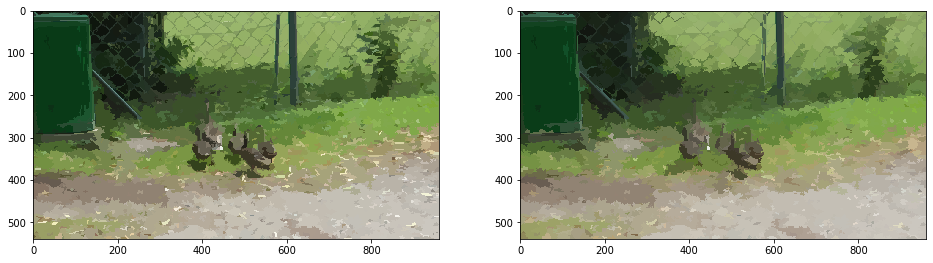

In [ ]:
segments_fz = felzenszwalb(patos, scale=100, sigma=0.8, min_size=30)
out1_felz = label2rgb(segments_fz, patos, kind='avg')

g = rag_mean_color(patos, segments_fz)
labels2 = cut_normalized(segments_fz, g, 29)
out2 = label2rgb(labels2, patos, kind='similarity')

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

ax[0].imshow(out1_felz)
ax[1].imshow(out2)

En este filtro se observa que se tiene mayor granularidad que no logra realizar una segmentación más clara de los colores y las figuras de los patos. no genera mejor resultado con respecto al primero probado.

### Quickshift 

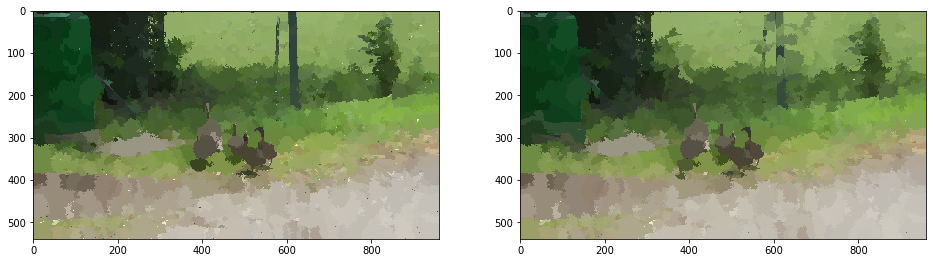

In [ ]:
segments_quick = quickshift(patos, kernel_size=10, max_dist=6, ratio=0.5)
out1_quick = label2rgb(segments_quick, patos, kind='avg')

g = rag_mean_color(patos, segments_quick)
labels2 = cut_normalized(segments_quick, g, 29)
out2 = label2rgb(labels2, patos, kind='similarity')

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

ax[0].imshow(out1_quick)
ax[1].imshow(out2)

Este filtro logra una mejor segmentación de las siluetas de los patos pero mantiene una paleta de colores más amplia. 

### Prueba de clusterización

La prueba de clusterización se realiza sobre el mejor resultado de segmentación que corresponde al algorimto SLIC. La pruena de clusterización se realiza siguiendo la guía del artículo:

https://buzzrobot.com/dominant-colors-in-an-image-using-k-means-clustering-3c7af4622036

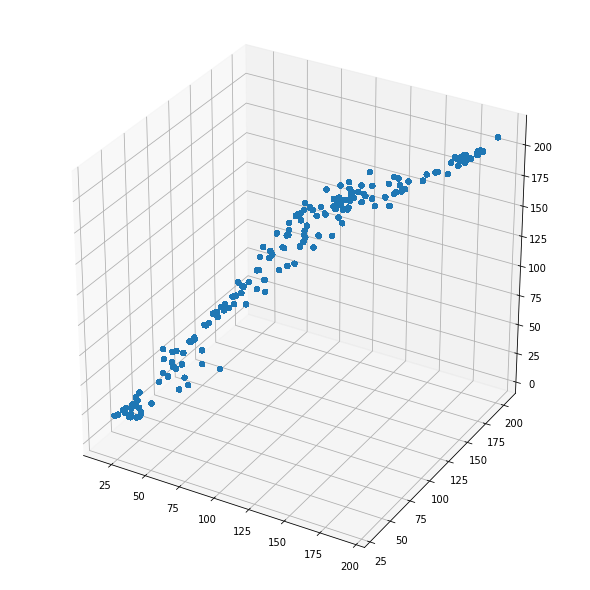

In [ ]:
# Representación en 3D del conjunto de pixeles por colores

#convert from BGR to RGB
imagen_patos = cv2.cvtColor((out1_slic*255).astype('uint8'), cv2.COLOR_BGR2RGB)

r, g, b = cv2.split(imagen_patos)
r = r.flatten()
g = g.flatten()
b = b.flatten()

#plotting 
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

Se puede observar que visualmente es distingur los grupos de colores

In [ ]:
# Se implementa una función de clusterización según el artículo del portal web:
# https://buzzrobot.com/dominant-colors-in-an-image-using-k-means-clustering-3c7af4622036

class DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    
    def __init__(self, img, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = img
        
    def dominantColors(self):
    
        #read image
        img = self.IMAGE
        

        #convert to rgb from bgr
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
        #reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        
        #save image after operations
        self.IMAGE = img
        
        #using k-means to cluster pixels
        kmeans = KMeans(n_clusters = self.CLUSTERS)
        kmeans.fit(img)
        
        #the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_
        
        #save labels
        self.LABELS = kmeans.labels_
        
        #returning after converting to integer from float
        return self.COLORS.astype(int)
    
    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))
    
    def plotClusters(self):
        #plotting 
        fig = plt.figure()
        ax = Axes3D(fig)        
        for label, pix in zip(self.LABELS, self.IMAGE):
            ax.scatter(pix[0], pix[1], pix[2], color = self.rgb_to_hex(self.COLORS[label]))
        plt.show()
        
    def plotHistogram(self):
       
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end	
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()

Vector de colores significtivos


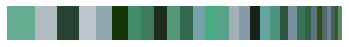

In [ ]:
# Se ejecuta la clusterización de la imagen

clusters = 30
dc = DominantColors(imagen_patos, clusters) 
colors = dc.dominantColors()

print('Vector de colores significativos')
dc.plotHistogram()

#dc.plotClusters()

## Prueba de clusterización con cv2 

Se realiza una prubea de clusterización con CV2 para determinar si se puede disminuir de 30 a menos grupos de color para la segmentación. A continuación se presenta el ejemplo utilizando 20 grupos.

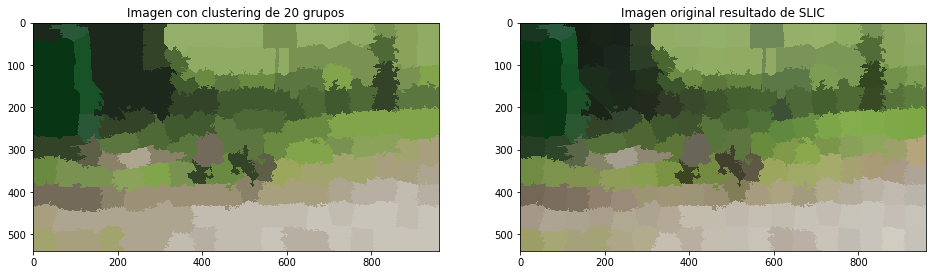

In [ ]:
# clusterización de imagenes a partir de la librería CV2 basado en el artículo:
# https://www.thepythoncode.com/article/kmeans-for-image-segmentation-opencv-python

pixel_values = (out1_slic*255).reshape((-1, 3)) 
pixel_values = np.float32(pixel_values)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

k = 25
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
labels = labels.flatten()

segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(out1_slic.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

ax[0].imshow(segmented_image)
ax[1].imshow(out1_slic)
ax[0].set_title("Imagen con clustering de 20 grupos", fontsize=12)
ax[1].set_title("Imagen original resultado de SLIC", fontsize=12)

plt.show()

Se puede observar que menos grupos de colores genera menos capacidad de segmentación de los patos, ya que los colores se confunde con los colores de fondo.

# Filtrado por capa de colores

tomando ventaja la segmentación de colores realizada mediante los algoritmos anteriores se busca el rando de colores que aplica para las imagenes de los patos, para ello se hace un análisis de los colores en los rangos RGB y HSV.

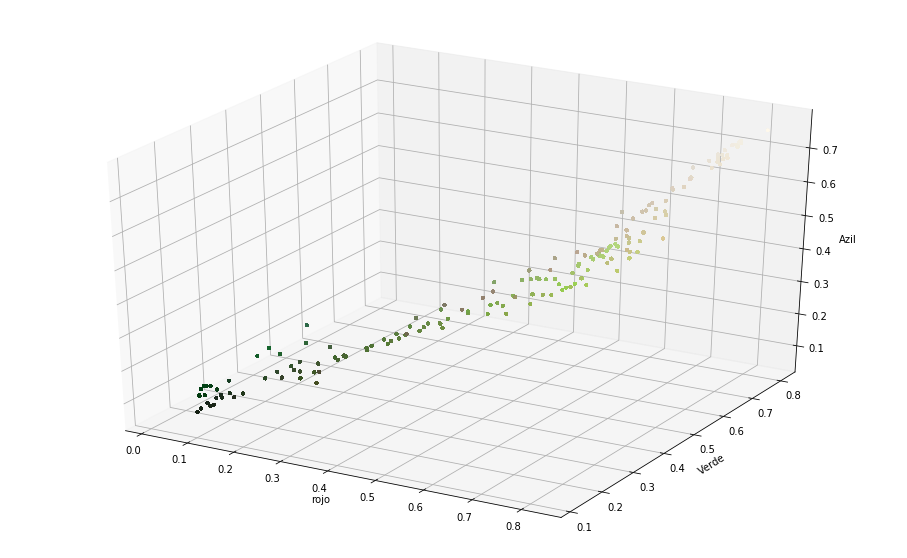

In [ ]:
# Graficado en 3D de los pixeles de la imagen filtrada con los valores RGB

imagen_filtrado = out1_slic

r, g, b = cv2.split(imagen_filtrado)
fig = plt.figure(figsize=(16, 10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = imagen_filtrado.reshape((np.shape(imagen_filtrado)[0]*np.shape(imagen_filtrado)[1], 3))
norm = Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("rojo")
axis.set_ylabel("Verde")
axis.set_zlabel("Azil")
plt.show()

In [ ]:
# Se convierten los colores al formato HSV
hsv_ducks = cv2.cvtColor((imagen_filtrado*255).astype('uint8'), cv2.COLOR_RGB2HSV)

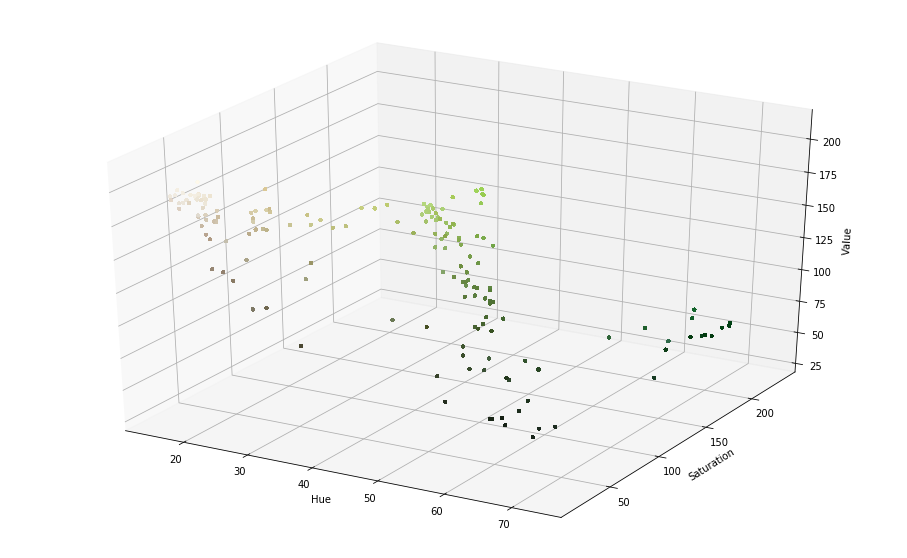

In [ ]:
# Graficado en 3D de los pixeles de la imagen filtrada con los valores RGB
h, s, v = cv2.split(hsv_ducks)
fig = plt.figure(figsize=(16, 10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

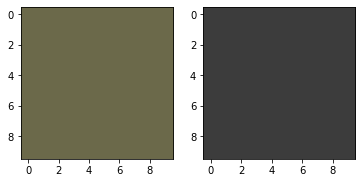

In [ ]:
# Se genera el tango de colores para aplicar el filtro en el rango claro (light) y el rango oscuro(dark) 
#que se aplicará para el filtrado de la imagen

light_limit = (21, 0, 60)
dark_limit = (40, 77, 107)

lo_square = np.full((10, 10, 3), light_limit, dtype=np.uint8) /255-0
do_square = np.full((10, 10, 3), dark_limit, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

In [ ]:
# Se crea la máscara de recorte a partir de los límites de colores definidos en el paso anterior

mask = cv2.inRange(hsv_ducks, light_limit, dark_limit)
result = cv2.bitwise_and(out1_slic, out1_slic, mask=mask)

# Resultado esperado

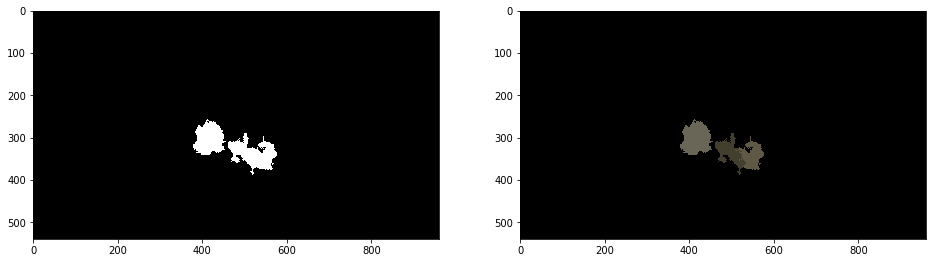

In [ ]:
#Resultado final

fig = plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

### Cálculo de error

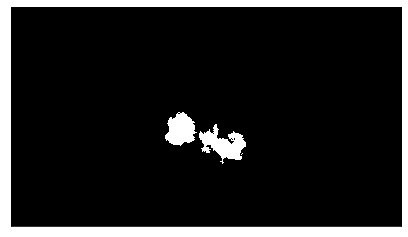

In [ ]:
imshow(mask)

In [ ]:
#Se calcula el error con la función factor_f_evaluation
factor_f_evaluation(mask, gt_patos)

0.8166923400084022

## Conclusiones 

Para realizar el ejercicio se utilizaron los algoritmos felzenszwalb, quickshift, slic para ejecutar una segmentación de colores, basado en la fusión de pixeles para disminuir la cantidad de colores. A partir de esta segmentación base se crea una mascar de filtro de colores en el modelo HSV para retirar los colores de las áreas diferentes a los patos. El filtro de color se diseña a partir del análisis del clúster en donde se identifican los clores más relevantes con una venta de filtrado. como resultado del ejercicio se tiene un factor de score (f_score) con 82% para el mejor filtrado realizado.